Initial DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.3+ KB
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  

<Figure size 1200x800 with 0 Axes>

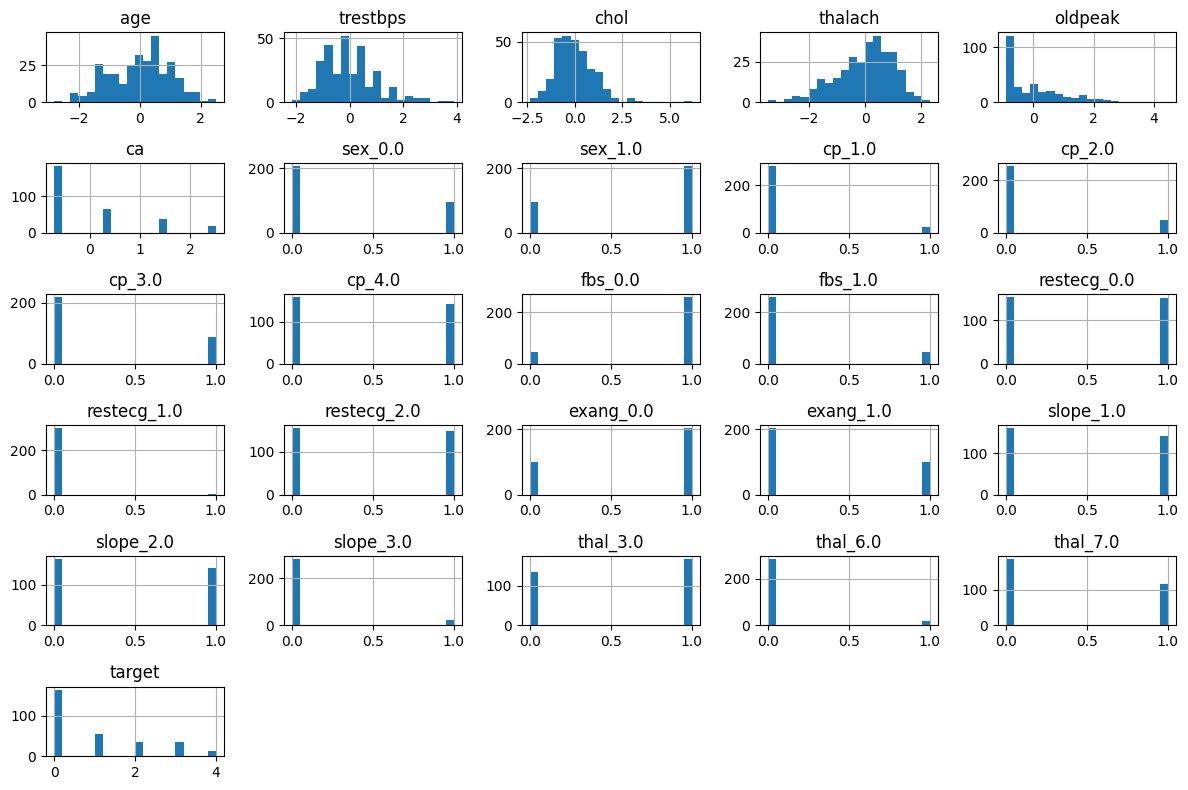

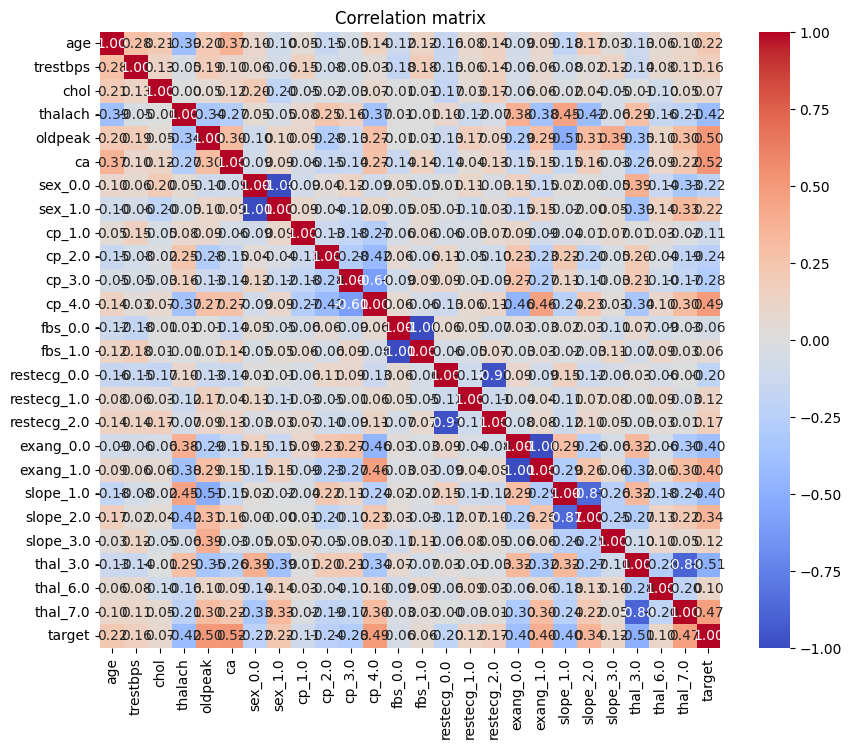

In [6]:
# 01_data_preprocessing_fixed.py

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# -----------------------------
# Paths
# -----------------------------
RAW_DATA_PATH = r"E:\Projects\Python Projects\ML\heart-disease-ml\processed.cleveland.data.csv"       # original raw dataset
CLEANED_PATH = "data/processed_cleaned.csv"      # cleaned dataset output

# Ensure output folder exists
os.makedirs(os.path.dirname(CLEANED_PATH), exist_ok=True)

# -----------------------------
# 1. Load raw dataset
# -----------------------------
df = pd.read_csv(RAW_DATA_PATH, header=None)
df.columns = [
    "age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang",
    "oldpeak","slope","ca","thal","target"
]

print("Initial DataFrame info:")
df.info()
print(df.head())

# -----------------------------
# 2. Replace '?' with NaN and convert numeric columns
# -----------------------------
df = df.replace('?', np.nan)

numeric_cols = ["age","trestbps","chol","thalach","oldpeak","ca"]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# -----------------------------
# 3. Identify categorical columns
# -----------------------------
categorical_cols = [c for c in df.columns if c not in numeric_cols + ['target']]

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

# -----------------------------
# 4. Preprocessing pipelines
# -----------------------------
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='drop'
)

# -----------------------------
# 5. Fit transform
# -----------------------------
X = df.drop(columns=['target'])
y = df['target']

X_trans = preprocessor.fit_transform(X)

# Build transformed column names
ohe_cols = []
if categorical_cols:
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    ohe_cols = ohe.get_feature_names_out(categorical_cols).tolist()

transformed_cols = numeric_cols + ohe_cols
df_clean = pd.DataFrame(X_trans, columns=transformed_cols)
df_clean['target'] = y.values

# -----------------------------
# 6. Save cleaned CSV
# -----------------------------
df_clean.to_csv(CLEANED_PATH, index=False)
print("Saved cleaned dataset to:", CLEANED_PATH)

# -----------------------------
# 7. EDA: distributions & correlation
# -----------------------------
plt.figure(figsize=(12, 8))
df_clean.hist(bins=20, figsize=(12,8))
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(df_clean.corr(), annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation matrix")
plt.show()
